# Poznań - Real estate market analysis and ML

## Description

## 1. Introduce

Main purpose of this document is understanding of situation on Poznan flat market. Second part of document is trying to fit ML model to predict price of flat. 

## 2. Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import random
import scipy
import plotly.plotly as py
import plotly.graph_objs as go
import sklearn
from sklearn import svm
from scipy import stats
from matplotlib import style
from IPython.core.display import display, HTML
style.use("fivethirtyeight")

%matplotlib inline
plt.rcParams["figure.figsize"] = [9,6]
pd.set_option('float_format', '{:.0f}'.format)

## 3. User-definied functions

In [2]:
analysis_headers = ["CENA", "CENA_M2", "POWIERZCHNIA", "POKOJE", "ROK_BUDOWY", "DZIELNICA"]
district_headers = ['Antoninek','Zieliniec','Kobylepole','Chartowo','Fabianowo','Kotowo','Główna','Głuszyna',
                    'Górczyn','Grunwald','Jana III Sobieskiego','Jeżyce','Junikowo','Kiekrz','Krzesiny',
                    'Pokrzywno','Garaszewo','Krzyżowniki','Smochowice','Kwiatowe','Ławica','Morasko','Radojewo',
                    'Naramowice','Winogrady','Ogrody','Ostrów Tumski','Śródka','Zawady','Komandoria','Piątkowo',
                    'Podolany','Rataje','Sołacz','Stare Miasto','Stare Winogrady','Starołęka','Minikowo',
                    'Marlewo','Stary Grunwald','Strzeszyn','Szczepankowo','Spławie','Krzesinki','Łazarz',
                    'Świerczewo','Umultowo','Warszawskie','Pomet','Maltańskie','Wilda','Winiary','Wola',
                    'Zielony Dębiec','Żegrze','Dębiec','','NaN','NA']
var_dictionary   = {"CENA":"Price", "CENA_M2":"Price_M2", "POWIERZCHNIA":"Surface", "POKOJE":"Rooms", 
                    "ROK_BUDOWY":"Year of building", "DZIELNICA":"District"}

In [3]:
def Filtered(dataset, price_min = None, price_max = None, start_year = None, end_year = None, min_surface = None, 
             max_surface = None, min_rooms = None, max_rooms = None, district = None, market = None):
    """function for data filter, returns dataframe"""
    
    if price_min is not None:
        dataset = dataset[(dataset["CENA"] >= price_min)]
    if price_max is not None:
        dataset = dataset[(dataset["CENA"] <= price_max)]
    if start_year is not None:
        dataset = dataset[(dataset["ROK_BUDOWY"] >= start_year)]
    if end_year is not None:
        dataset = dataset[(dataset["ROK_BUDOWY"] <= end_year)]
    if min_surface is not None:
        dataset = dataset[(dataset["POWIERZCHNIA"] >= min_surface)]
    if max_surface is not None:
        dataset = dataset[(dataset["POWIERZCHNIA"] <= max_surface)]
    if min_rooms is not None:
        dataset = dataset[(dataset["POKOJE"] >= min_rooms)]
    if max_rooms is not None:
        dataset = dataset[(dataset["POKOJE"] <= max_rooms)]
    if district is not None:
        dataset = dataset[dataset["DZIELNICA"] == district]
    if market is not None:
        dataset = dataset[(dataset["RYNEK"] == market)]
    return dataset

In [4]:
def HistogramPlot(variable, dataset):
    """function for plotting data, returns histogram plot"""
    
    data_array = np.array((dataset[[variable]]))
    hist_data = np.histogram(data_array)
    binsize = hist_data[1][1] - hist_data[1][0]
    
    trace1 = go.Histogram(
        x=data_array,
        histnorm='count',
        name=random.randint(0,100000),
        autobinx=False,
        xbins=dict(
            start=hist_data[1][0],
            end=hist_data[1][-1],
            size=binsize)
    )

    trace_data = [trace1]
    layout = go.Layout(
        bargroupgap=0.3,
        title='Distribution of: '+variable,
        xaxis=dict(
            title=variable,
            titlefont=dict(
                family='Courier New, monospace',
                size=18,
                color='#7f7f7f'
                )
            ),
        yaxis=dict(
            title='Number of offers',
            titlefont=dict(
                family='Courier New, monospace',
                size=18,
                color='#7f7f7f'
            )
        )
    )
    fig = go.Figure(data=trace_data, layout=layout)
    return py.iplot(fig)
    

In [5]:
def Statistics(dataset):
    """function for statistics description data, returns dataframe"""
    pd.set_option('float_format', '{:.0f}'.format)
    
    df = pd.DataFrame()
    try:
        df = df.append({"Description":"Number of offers all:" , "Value":len(dataset.index)},
                       ignore_index=True)
        df = df.append({"Description":"Number of offers on primary market:" , "Value":len(dataset[(dataset["RYNEK"] == "pierwotny")].index)},
                       ignore_index=True)
        df = df.append({"Description":"Number of offers on secondary market:" , "Value":len(dataset[(dataset["RYNEK"] == "wtórny")].index)},
                       ignore_index=True)
        df = df.append({"Description":"Average price for square meter:" , "Value":dataset["CENA_M2"].mean()},
                       ignore_index=True)
        df = df.append({"Description":"Average price for square meter primary market:" , "Value":dataset[(dataset["RYNEK"] == "pierwotny")]["CENA_M2"].mean()},
                       ignore_index=True)
        df = df.append({"Description":"Average price for square meter secondary market:" , "Value":dataset[(dataset["RYNEK"] == "wtórny")]["CENA_M2"].mean()},
                       ignore_index=True)
        df = df.append({"Description":"Average surface of flat:" , "Value":dataset["POWIERZCHNIA"].mean()},
                       ignore_index=True)
        df = df.append({"Description":"Average surface of flat on primary market:" , "Value":dataset[(dataset["RYNEK"] == "pierwotny")]["POWIERZCHNIA"].mean()},
                       ignore_index=True)
        df = df.append({"Description":"Average surface of flat on secondary market:" , "Value":dataset[(dataset["RYNEK"] == "wtórny")]["POWIERZCHNIA"].mean()},
                       ignore_index=True)
        df = df.append({"Description":"Average price all:" , "Value":dataset["CENA"].mean()},
                       ignore_index=True)
        df = df.append({"Description":"Average price on primary market:" , "Value":dataset[(dataset["RYNEK"] == "pierwotny")]["CENA"].mean()},
                       ignore_index=True)
        df = df.append({"Description":"Average price on secondary market:" , "Value":dataset[(dataset["RYNEK"] == "wtórny")]["CENA"].mean()},
                       ignore_index=True)
        df = df.append({"Description":"Max price:" , "Value":max(dataset["CENA"])},
                       ignore_index=True)
        df = df.append({"Description":"Max price on primary market:" , "Value":max(dataset[(dataset["RYNEK"] == "pierwotny")]["CENA"])},
                       ignore_index=True)
        df = df.append({"Description":"Max price on secondary market:" , "Value":max(dataset[(dataset["RYNEK"] == "wtórny")]["CENA"])},
                       ignore_index=True)
        df = df.append({"Description":"Min price:" , "Value":min(dataset["CENA"])},
                       ignore_index=True)
        df = df.append({"Description":"Min price on primary market:" , "Value":min(dataset[(dataset["RYNEK"] == "pierwotny")]["CENA"])},
                       ignore_index=True)
        df = df.append({"Description":"Min price on secondary market:" , "Value":min(dataset[(dataset["RYNEK"] == "wtórny")]["CENA"])},
                       ignore_index=True)
    except ValueError:
        print("\nWarning: You have set filter on market - some data is unavaiable")
    return display(HTML(df.to_html(index=False)))

In [6]:
def AveragePerVariable(dataset, variable_group, variable_value1):
    dataset = dataset[[variable_group, variable_value1]]
    dataset = dataset.groupby([variable_group]).agg(["mean","size"])
    if variable_value1 == "ROK_BUDOWY":
        dataset = dataset.sort_values(by = (variable_value1, "size"), ascending = False)
    else:
        dataset = dataset.sort_values(by = (variable_value1, "mean"), ascending = False)
    dataset = dataset.round(0)
    return dataset

In [7]:
def ShapiroResults(dataset, variable):
    shapiro_results = scipy.stats.shapiro(dataset[[variable]])
    if shapiro_results[1] <= 0.0001:
        asterisk = "****"
    elif shapiro_results[1] <=0.001:
        asterisk = "***"
    elif shapiro_results[1] <= 0.01:
        asterisk = "**"
    elif shapiro_results[1] <= 0.01:
        asterisk = "**"
    elif shapiro_results[1] <= 0.05:
        asterisk = "*"
    else:
        asterisk = "ns"
    df = pd.DataFrame()
    df = df.append({"Test for":var_dictionary[variable],"Test Statistics":shapiro_results[0],
                    "p-value":shapiro_results[1], "Label":asterisk}, ignore_index = True)
    df = df[["Test for", "Test Statistics", "p-value", "Label"]]
    return display(HTML(df.to_html(index=False)))
    


## 4. Dataset
Dataset is a csv file and content data about flats for sale in Poznan in February 2018 from website olx.pl. I have collected data by web scraping method. All code for import data is in scripts into repository. In this analyse I use DataFrame from pandas. 

In [8]:
dataset = pd.read_csv("C:/Users/Przemek/PycharmProjects/Real estate scrapping OtoDom/real_estate_data.csv", 
                      sep=";",index_col=2)
dataset = pd.DataFrame(dataset)

In dataset exist duplicated data - for example awarded offers which are on every page, so in below code I delete duplciates data

In [9]:
dataset = dataset[~dataset.index.duplicated(keep="first")]

# Analysis

## 1. Overall summary

In this point you can see, some particular statistics about data.

In [10]:
Statistics(dataset)

Description,Value
Number of offers all:,3214
Number of offers on primary market:,1418
Number of offers on secondary market:,1795
Average price for square meter:,6511
Average price for square meter primary market:,6560
Average price for square meter secondary market:,6471
Average surface of flat:,60
Average surface of flat on primary market:,56
Average surface of flat on secondary market:,64
Average price all:,386197


## 2. Static analysis of different variables

In this part of statement you can see distribution of different variables with different conditions. For me the most interesting flats are:
* 2/3 rooms
* no matter of type of market
* surface between 40 and 65 square meters
* building shoudn't be old, so year of building > 2005 
* price between 230k and 330k 

At the begginig I use Shapiro Wilk test to ensure, if data with above condtions has normallity distibution.

Let's check data!

## Shapiro Wilk test

* <i>H0:</i> Price per square meter in price range 230k - 330k has normallity distribuation

Filtered data sample has really low p-value, so we don't have reason to exclude <i>H0</i>. We can assume that distribution of Price, Price_M2, Surface, Rooms is normally. It's good news because thanks that we can use a lot of statistician methods for this sample

In [11]:
pd.set_option('float_format', '{:.5f}'.format)
fdataset = Filtered(dataset, min_rooms = 2, max_rooms = 3, min_surface = 40, max_surface = 65, price_min = 230000,
                    price_max = 330000)

ShapiroResults(fdataset,"CENA")
ShapiroResults(fdataset,"CENA_M2")
ShapiroResults(fdataset,"POWIERZCHNIA")
ShapiroResults(fdataset,"POKOJE")

Test for,Test Statistics,p-value,Label
Price,0.96992,0.00000,****


Test for,Test Statistics,p-value,Label
Price_M2,0.99159,0.00003,****


Test for,Test Statistics,p-value,Label
Surface,0.94802,0.00000,****


Test for,Test Statistics,p-value,Label
Rooms,0.57075,0.00000,****


## Price

In [12]:
fdataset = Filtered(dataset, min_rooms = 2, max_rooms = 3, min_surface = 40, max_surface = 65)
Statistics(fdataset)
HistogramPlot("CENA", fdataset)

Description,Value
Number of offers all:,1733
Number of offers on primary market:,849
Number of offers on secondary market:,884
Average price for square meter:,6538
Average price for square meter primary market:,6556
Average price for square meter secondary market:,6520
Average surface of flat:,51
Average surface of flat on primary market:,51
Average surface of flat on secondary market:,52
Average price all:,334757


In [13]:
fdataset = Filtered(dataset, min_rooms = 2, max_rooms = 3, min_surface = 40, max_surface = 65, price_min = 230000,
                    price_max = 330000)
Statistics(fdataset)
HistogramPlot("CENA", fdataset)

Description,Value
Number of offers all:,957
Number of offers on primary market:,490
Number of offers on secondary market:,467
Average price for square meter:,6098
Average price for square meter primary market:,6273
Average price for square meter secondary market:,5914
Average surface of flat:,48
Average surface of flat on primary market:,47
Average surface of flat on secondary market:,49
Average price all:,291659


In [14]:
fdataset = Filtered(dataset, min_rooms = 2, max_rooms = 3, min_surface = 40, max_surface = 65, price_min = 230000,
                  price_max = 330000, market = "wtórny")
Statistics(fdataset)
HistogramPlot("CENA", fdataset)

Description,Value
Number of offers all:,467
Number of offers on primary market:,0
Number of offers on secondary market:,467
Average price for square meter:,5914
Average price for square meter primary market:,nan
Average price for square meter secondary market:,5914
Average surface of flat:,49
Average surface of flat on primary market:,nan
Average surface of flat on secondary market:,49
Average price all:,288441


In [15]:
fdataset = Filtered(dataset, min_rooms = 2, max_rooms = 3, min_surface = 40, max_surface = 65, price_min = 230000,
                    price_max = 330000, market = "pierwotny")
Statistics(fdataset)
HistogramPlot("CENA", fdataset)

Description,Value
Number of offers all:,490
Number of offers on primary market:,490
Number of offers on secondary market:,0
Average price for square meter:,6273
Average price for square meter primary market:,6273
Average price for square meter secondary market:,nan
Average surface of flat:,47
Average surface of flat on primary market:,47
Average surface of flat on secondary market:,nan
Average price all:,294726


## Price per square meter

It's short look into distribution of price per square meter for flats where price is in range 230k-330k. After first look into histogram (espacially in scondary market) I noticed that price per square meter can have gausiann distribuation. Related with this findings I check it by Shapiro-Wilk test with 
* <i>H0:</i> Price per square meter in price range 230k - 330k has normallity distribuation

I ommited here global distiribution becuase it is really resemblence like price distribuation.

In [16]:
fdataset = Filtered(dataset, min_rooms = 2, max_rooms = 3, min_surface = 40, max_surface = 65, price_min = 230000,
                    price_max = 330000)
HistogramPlot("CENA_M2", fdataset)

In [17]:
fdataset = Filtered(dataset, min_rooms = 2, max_rooms = 3, min_surface = 40, max_surface = 65, price_min = 230000,
                    price_max = 330000, market = "wtórny")
HistogramPlot("CENA_M2", fdataset)

In [18]:
fdataset = Filtered(dataset, min_rooms = 2, max_rooms = 3, min_surface = 40, max_surface = 65, price_min = 230000,
                    price_max = 330000, market = "pierwotny")
HistogramPlot("CENA_M2", fdataset)


## Surface

In [19]:
fdataset = Filtered(dataset, min_rooms = 2, max_rooms = 3, min_surface = 40, max_surface = 65, price_min = 230000,
                    price_max = 330000)
HistogramPlot("POWIERZCHNIA", fdataset)

## Rooms

In [20]:
fdataset = Filtered(dataset, min_rooms = 2, max_rooms = 3, min_surface = 40, max_surface = 65, price_min = 230000,
                    price_max = 330000)
fdataset = fdataset.groupby(["POKOJE"]).size().reset_index(name="QUANTITY").sort_values(by="QUANTITY", ascending = False)
display(HTML(fdataset.to_html(index=False)))


POKOJE,QUANTITY
2,677
3,280


In [21]:
fdataset = Filtered(dataset, min_rooms = 1, max_rooms = 10)
fdataset = fdataset.groupby(["POKOJE"]).size().reset_index(name="QUANTITY").sort_values(by="QUANTITY", ascending = False)
display(HTML(fdataset.to_html(index=False)))

POKOJE,QUANTITY
2,1300
3,1122
4,408
1,272
5,76
6,18
7,7
9,5
10,3
8,2


## Bachelor apartment

In [22]:
fdataset = Filtered(dataset, min_rooms = 1, max_rooms = 1)
Statistics(fdataset)
HistogramPlot("CENA_M2", fdataset)

Description,Value
Number of offers all:,272
Number of offers on primary market:,107
Number of offers on secondary market:,165
Average price for square meter:,7201
Average price for square meter primary market:,7557
Average price for square meter secondary market:,6971
Average surface of flat:,34
Average surface of flat on primary market:,35
Average surface of flat on secondary market:,33
Average price all:,238480


## Highest price districts in Poznan

In [23]:
pd.set_option('float_format', '{:.0f}'.format)
fdataset = dataset
AveragePerVariable(fdataset,"DZIELNICA","CENA_M2")

CENA_M2     
                        mean size
DZIELNICA                        
Ostrów Tumski           8438    1
Stare Miasto            7662  149
Sołacz                  7457   57
Górczyn                 6920   71
Świerczewo              6833    1
Śródka                  6812   21
Zawady                  6787   10
Winogrady               6779  157
Ławica                  6637    2
Zieliniec               6588    7
Umultowo                6574    2
Grunwald                6545  554
Wilda                   6417  301
Strzeszyn               6400   50
Chartowo                6375   13
Jeżyce                  6361  150
Żegrze                  6326   29
Ogrody                  6323   37
Łazarz                  6301   87
Wola                    6202    3
Naramowice              6188  128
Piątkowo                6142  105
Komandoria              6058    2
Jana III Sobieskiego    6014    2
Rataje                  6013  186
Winiary                 5957   12
Junikowo                5853    8
Podolany                5651   79
Antoninek               5644    8
Dębiec                  5624   37
Smochowice              5530    5
Starołęka               5464   22
Główna                  5442   16
Morasko                 5099    1
Głuszyna                4830   18
Szczepankowo            4556   22
Kotowo                  4440    2
Pokrzywno               4433    1
Warszawskie             3556    3

## Highest price per year of building

In [24]:
fdataset = Filtered(dataset, start_year = 2000, end_year = 2030)
AveragePerVariable(fdataset,"ROK_BUDOWY","CENA_M2")

CENA_M2     
              mean size
ROK_BUDOWY             
2013          9503   18
2009          8435   52
2014          8403   20
2010          8150   30
2011          7889   26
2008          7727   57
2015          7605   34
2012          7516   20
2005          7248   21
2002          7034   13
2006          7004   32
2007          6996   33
2003          6881   12
2020          6797    3
2001          6614   25
2016          6563  117
2019          6526  243
2018          6509  436
2017          6431  235
2004          6385   10
2000          6362   48

## Most popular districts to building new flats

In [25]:
fdataset = Filtered(dataset, start_year = 2018, end_year = 2030)
AveragePerVariable(fdataset,"DZIELNICA","ROK_BUDOWY")

ROK_BUDOWY     
                   mean size
DZIELNICA                   
Grunwald           2019  197
Wilda              2019   43
Stare Miasto       2018   29
Strzeszyn          2018   25
Naramowice         2019   23
Sołacz             2018   18
Górczyn            2018   17
Żegrze             2019   15
Winogrady          2018   13
Ogrody             2018   11
Szczepankowo       2018    7
Główna             2018    7
Jeżyce             2018    5
Rataje             2018    3
Zawady             2018    3
Podolany           2018    2
Starołęka          2018    2
Morasko            2018    1
Kotowo             2018    1
Junikowo           2018    1
Zieliniec          2018    1
Śródka             2018    1
Smochowice         2018    1

## Correlate

In [26]:
pd.set_option('float_format', '{:.3f}'.format)
fdataset = dataset
fdataset.corr()

,CENA,CENA_M2,POWIERZCHNIA,POKOJE,PIĘTRO,ROK_BUDOWY,CZYNSZ
CENA,1.000,0.522,0.723,0.489,-0.002,0.002,0.512
CENA_M2,0.522,1.000,-0.114,-0.190,0.109,0.080,0.056
POWIERZCHNIA,0.723,-0.114,1.000,0.767,-0.107,-0.079,0.467
POKOJE,0.489,-0.190,0.767,1.000,-0.058,-0.019,0.411
PIĘTRO,-0.002,0.109,-0.107,-0.058,1.000,0.049,0.081
ROK_BUDOWY,0.002,0.080,-0.079,-0.019,0.049,1.000,0.049
CZYNSZ,0.512,0.056,0.467,0.411,0.081,0.049,1.000


In [27]:
pd.set_option('float_format', '{:.3f}'.format)
fdataset = fdataset = Filtered(dataset, price_min = 230000, price_max = 330000)
fdataset.corr()

,CENA,CENA_M2,POWIERZCHNIA,POKOJE,PIĘTRO,ROK_BUDOWY,CZYNSZ
CENA,1.000,0.014,0.438,0.341,0.066,0.066,0.261
CENA_M2,0.014,1.000,-0.815,-0.524,0.048,0.114,-0.310
POWIERZCHNIA,0.438,-0.815,1.000,0.602,-0.037,-0.117,0.321
POKOJE,0.341,-0.524,0.602,1.000,0.026,-0.036,0.328
PIĘTRO,0.066,0.048,-0.037,0.026,1.000,0.033,0.244
ROK_BUDOWY,0.066,0.114,-0.117,-0.036,0.033,1.000,-0.045
CZYNSZ,0.261,-0.310,0.321,0.328,0.244,-0.045,1.000


## Findigs about flats from point (2)

--dodac podsumowanie i opisy do powyższych kroków i uszergować to w porządny logiczny ciąg

## Let's try some Machine Learning

* sprobowac zrobic regresje, svm, drzewo, jakis klasyfikator, porozbijac te dane
* zaleznosci mozna na calym zbiorze np cena vs liczba pokoi, cena vs wyposazenie
* cena od powierzchni ale nie histogramy
* ceny wzgledem dzielnic tez na calosci - glownie mediany
* wiecej danych jakosciowych
* sprobuj sie pobawic regresja, svm etc

## Preparing dataset

In [28]:
pd.set_option('float_format', '{:.0f}'.format)
train = Filtered(dataset, price_min = 200000, price_max = 400000)
train.head()
train = train[["CENA","CENA_M2","POWIERZCHNIA","POKOJE","PIĘTRO","RYNEK", "ROK_BUDOWY", "STAN_WYKOŃCZENIA", 
               "FORMA_WŁASNOŚCI"]]

In [29]:
train.describe()

,CENA,CENA_M2,POWIERZCHNIA,POKOJE,PIĘTRO,ROK_BUDOWY
count,2188,2188,2188,2188,1688,1412
mean,310044,6238,51,2,3,1995
std,49953,1084,13,1,2,96
min,200000,2040,23,1,1,1
25%,273952,5650,43,2,1,1988
50%,309400,6209,49,2,3,2016
75%,349000,6700,58,3,4,2018
max,400000,12176,125,8,10,2108


We can notice some suspected data, especially in max row. I checked this data and we should delete row where number of rooms is equal 277761 and row where year of building is equal 2108. 

In [30]:
train.drop(train[train["POKOJE"] == 277761].index, inplace = True)
train.drop(train[train["ROK_BUDOWY"] == 2108].index, inplace = True)
train.drop(train[train["ROK_BUDOWY"] == 1].index, inplace = True)
train.drop(train[train["ROK_BUDOWY"] == 70].index, inplace = True)
train.describe()

,CENA,CENA_M2,POWIERZCHNIA,POKOJE,PIĘTRO,ROK_BUDOWY
count,2184,2184,2184,2184,1684,1408
mean,310091,6239,51,2,3,1999
std,49972,1083,13,1,2,30
min,200000,2040,23,1,1,1898
25%,273952,5650,43,2,1,1989
50%,309400,6209,49,2,3,2016
75%,349000,6700,58,3,4,2018
max,400000,12176,125,8,10,2020


In this step I choose columns for ML and fill missing data in variables PIĘTRO and ROK_BUDOWY. You can notice that there are also qualitative data - we should map it to integres. We use for this lambda function. It's easy to convert variable RYNEK to numbers because always has only two values without nan. For variables STAN_WYKOŃCZENIA and FORMA_WŁASNOŚCI I will do following steps:
* check how many data is missing
* check percentage distribuation of missing data

The same steps I will do for missing data in PIĘTRO and ROK_BUDOWY.

From the below code we can see that 55% flats as 'do wykończenia' and 40% 'do zamieszkania'. In this case for missing data I will insert pseudo-random values 'do wykonczenia' and 'do zamieszkania'.

For 85% of data value in FORMA_WŁASNOŚCI is equal 'pełna własnośc'. In this case every missing data I substitue with 'pełna własność'

In [31]:
print(train.RYNEK.unique())
print(train.STAN_WYKOŃCZENIA.unique())
print(train.FORMA_WŁASNOŚCI.unique())

['wtórny' 'pierwotny']
['do wykończenia' 'do zamieszkania' nan 'do remontu']
['pełna własność' nan 'spółdzielcze wł. z KW' 'spółdzielcze własnościowe'
 'udział']


In [32]:
pd.set_option('float_format', '{:.2f}'.format)
print("Missing values: ", train.STAN_WYKOŃCZENIA.isnull().sum())
print("Perentage distribution: \n",
      train.groupby(["STAN_WYKOŃCZENIA"]).size()
      .apply(lambda x: x/(len(train.index)-train.STAN_WYKOŃCZENIA.isnull().sum())))

Missing values:  945
Perentage distribution: 
 STAN_WYKOŃCZENIA
do remontu        0.04
do wykończenia    0.59
do zamieszkania   0.37
dtype: float64


In [33]:
pd.set_option('float_format', '{:.2f}'.format)
print("Missing values: ",train.FORMA_WŁASNOŚCI.isnull().sum())
print("Percentage distribution: \n",
      train.groupby(["FORMA_WŁASNOŚCI"]).size()
      .apply(lambda x: x/(len(train.index)-train.FORMA_WŁASNOŚCI.isnull().sum())))

Missing values:  770
Percentage distribution: 
 FORMA_WŁASNOŚCI
pełna własność              0.83
spółdzielcze wł. z KW       0.08
spółdzielcze własnościowe   0.09
udział                      0.00
dtype: float64


In [34]:
train["RYNEK"] = train["RYNEK"].apply(lambda rynek:0 if rynek=="pierwotny" else  1)
train["STAN_WYKOŃCZENIA"] = train["STAN_WYKOŃCZENIA"].apply(lambda stan:0 if stan=="do remontu" else
                                                            (1 if stan=="do wykończenia" else 
                                                            (2 if stan=="do zamieszkania" else
                                                            random.randint(1,2))))
train["FORMA_WŁASNOŚCI"] = train["FORMA_WŁASNOŚCI"].apply(lambda forma:0 if forma=="pełna własność" else
                                                         (1 if forma=="spółdzielcze wł. z KW" else
                                                         (2 if forma=="spółdzielcze własnościowe" else
                                                         (3 if forma=="udział" else 0))))
train["ROK_BUDOWY"] = train["ROK_BUDOWY"].fillna(value=random.randint(2000,2020))
train["PIĘTRO"] = train["PIĘTRO"].fillna(value=random.randint(1,10))

In [35]:
pd.set_option('float_format', '{:.0f}'.format)
train.describe()

,CENA,CENA_M2,POWIERZCHNIA,POKOJE,PIĘTRO,RYNEK,ROK_BUDOWY,STAN_WYKOŃCZENIA,FORMA_WŁASNOŚCI
count,2184,2184,2184,2184,2184,2184,2184,2184,2184
mean,310091,6239,51,2,4,1,2004,1,0
std,49972,1083,13,1,3,0,25,1,1
min,200000,2040,23,1,1,0,1898,0,0
25%,273952,5650,43,2,2,0,2008,1,0
50%,309400,6209,49,2,3,1,2012,1,0
75%,349000,6700,58,3,8,1,2017,2,0
max,400000,12176,125,8,10,1,2020,2,3


So what is important for Machine Learning - we can see that not in every offers we have information about year of building and about rent. So we should fill this fields or ommit it in our model. In my opinon both of them are important and have influence on price. 

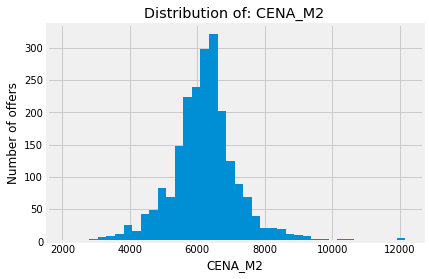

In [36]:
train = Filtered(train, price_max = 2000000)
train["CENA_M2"].hist(bins=40)
plt.title("Distribution of: CENA_M2")
plt.xlabel("CENA_M2")
plt.ylabel("Number of offers")
plt.show()

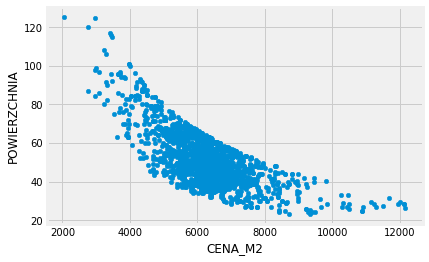

In [37]:
train.plot.scatter("CENA_M2","POWIERZCHNIA")

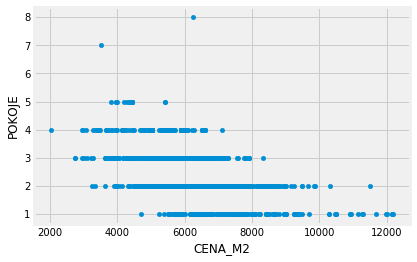

In [38]:
train.plot.scatter("CENA_M2","POKOJE")

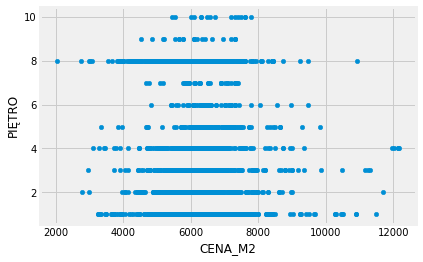

In [39]:
train.plot.scatter("CENA_M2","PIĘTRO")

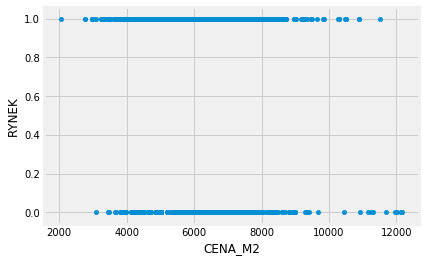

In [40]:
train.plot.scatter("CENA_M2","RYNEK")

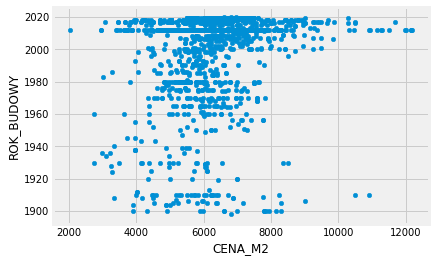

In [41]:
train.plot.scatter("CENA_M2","ROK_BUDOWY")

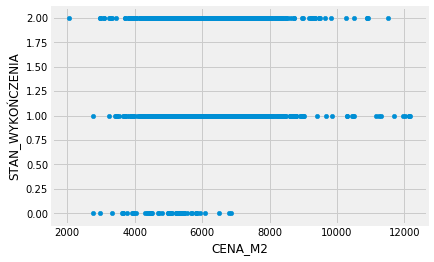

In [42]:
train.plot.scatter("CENA_M2","STAN_WYKOŃCZENIA")

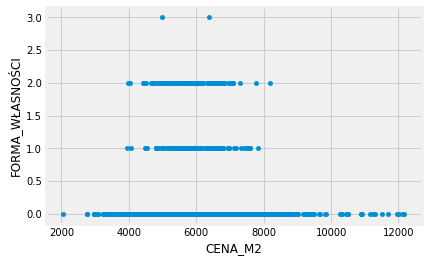

In [43]:
train.plot.scatter("CENA_M2","FORMA_WŁASNOŚCI")

## Multiple regression

* criterion variable is CENA_M2

In [44]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler

In [45]:
reg = LinearRegression()

In [46]:
labels = train["CENA_M2"]
data = train.drop(["CENA","CENA_M2"], axis=1)

In [47]:
pd.set_option('float_format', '{:.5f}'.format)
scaler = MinMaxScaler() 
scaled_values = scaler.fit_transform(data) 
data.loc[:,:] = scaled_values

In [48]:
from sklearn.cross_validation import train_test_split

c:\python34\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning:

This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.



In [49]:
x_train, x_test, y_train, y_test = train_test_split(data, labels, test_size = 0.20, random_state = 20)

In [50]:
reg.fit(x_train,y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [51]:
reg.score(x_test,y_test)

0.54239640117689492

Results of predicting data is 54%. It is weak result for me, so I will try apply gradient boosting regression. 

## Gradient Boosting Regression

In [52]:
from sklearn import ensemble
clf = ensemble.GradientBoostingRegressor(n_estimators = 200, max_depth = 7, min_samples_split=3, 
                                         learning_rate = 0.1, loss = "ls")
clf.fit(x_train,y_train)
clf.score(x_test,y_test)

0.72591395004160653

Results of predicting data is 72%